<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

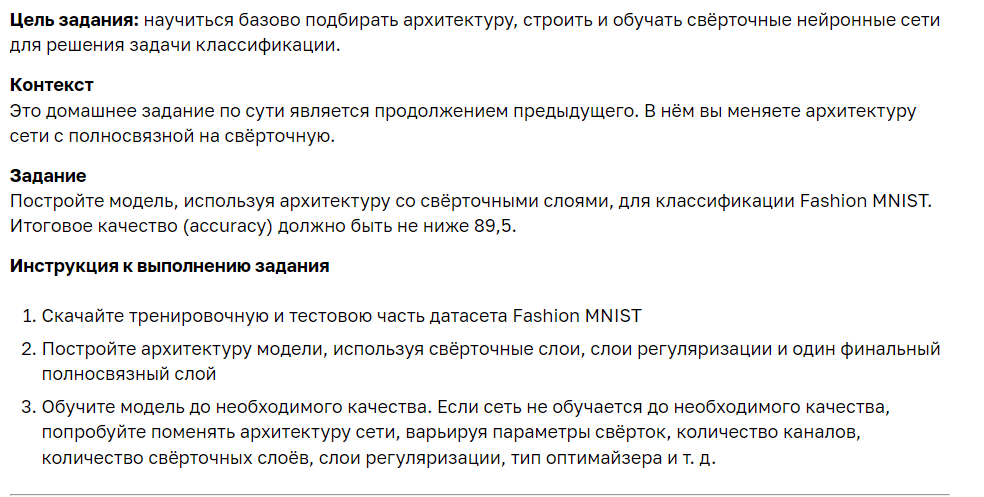

In [2]:
import torchvision as tv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time

In [3]:
BATCH_SIZE=64

In [4]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.ToTensor()
])

In [5]:
train_dataset = tv.datasets.MNIST('.',
                                  train=True,
                                  transform=transforms,
                                  download=True)

test_dataset = tv.datasets.MNIST('.',
                                 train=False,
                                 transform=transforms,
                                 download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16008211.79it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482352.89it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4392040.47it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12004113.91it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
train_dataset[0][0].shape

torch.Size([1, 32, 32])

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(16, 120, kernel_size=5),
    nn.Flatten(),
    torch.nn.Linear(120, 84),
    torch.nn.BatchNorm1d(84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)
)

In [25]:
from torchsummary import summary

summary(model, input_size=(1, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
           Flatten-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
      BatchNorm1d-10                   [-1, 84]             168
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,874
Trainable params: 61,874
Non-trainable params: 0
---------------------------------

In [8]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [9]:
def train(net, train_iter, test_iter, optimizer, num_epochs):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [28]:
lr, num_epochs = 0.01, 5
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, optimizer, num_epochs)

epoch 1, loss 0.0085, train acc 0.876, test acc 0.929, time 37.0 sec
epoch 2, loss 0.0032, train acc 0.950, test acc 0.963, time 37.8 sec
epoch 3, loss 0.0020, train acc 0.967, test acc 0.973, time 34.2 sec
epoch 4, loss 0.0015, train acc 0.973, test acc 0.976, time 36.6 sec
epoch 5, loss 0.0013, train acc 0.976, test acc 0.978, time 36.5 sec


In [ ]:
# Запустим модель на GPU

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
model = model.to(device)

In [12]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [13]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [15]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0200, train acc 0.742, test acc 0.849, time 13.2 sec
epoch 2, loss 0.0119, train acc 0.858, test acc 0.882, time 13.7 sec
epoch 3, loss 0.0092, train acc 0.880, test acc 0.896, time 13.3 sec
epoch 4, loss 0.0078, train acc 0.892, test acc 0.905, time 13.7 sec
epoch 5, loss 0.0069, train acc 0.899, test acc 0.912, time 13.2 sec


In [ ]:
# Подсчеты на видео карте значительно быстрее, но точность сильно хуже...

In [16]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0030, train acc 0.948, test acc 0.968, time 13.9 sec
epoch 2, loss 0.0014, train acc 0.974, test acc 0.977, time 13.4 sec
epoch 3, loss 0.0010, train acc 0.979, test acc 0.980, time 13.4 sec
epoch 4, loss 0.0008, train acc 0.983, test acc 0.982, time 13.3 sec
epoch 5, loss 0.0007, train acc 0.986, test acc 0.983, time 13.3 sec


In [ ]:
# Сочетание сверточных и полносвязных слаев дает отличной изначальный результат, работа на GPU сильно ускоряет вычисление матриц, а алгоритм оптимизации градиентного спуска Adam дает отличный результат.